In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")

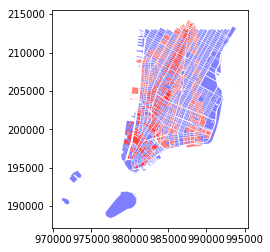

In [10]:
ax = pluto[(pluto.geometry.centroid.y < 213000) &\
           (~pluto.BBL.isin(np.unique(d6_bbls.ravel()))) &\
           (~pluto.BBL.isin(np.unique(d9_bbls.ravel())))].plot(color='blue', alpha=.5)
pluto[pluto.BBL.isin(np.unique(d6_bbls.ravel()))].plot(color='red', alpha=.5, ax=ax)
pluto[pluto.BBL.isin(np.unique(d9_bbls.ravel()))].plot(color='red', alpha=.5, ax=ax)

In [3]:
in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

In [10]:
dists = []
nearest_idxs = []
for ix, building in out_frame.iterrows():
    if ix % 1000 == 0:
        print("at", ix)
    ds = in_frame.geometry.distance(building.geometry)
    dists.append(ds.min())
    nearest_idxs.append(ds.idxmin())
    

at 2000
at 3000
at 7000
at 8000
at 9000
at 13000
at 14000
at 18000
at 20000
at 22000
at 23000
at 37000
at 40000


In [12]:
import joblib
joblib.dump(dists, "data/impute_dists.gz", 3)
joblib.dump(nearest_idxs, "data/impute_idxs.gz", 3)

['data/impute_idxs.gz']

< 1000: 0.8536083987959768
< 500: 0.7819543352176785
== 0: 0.27017105939358343


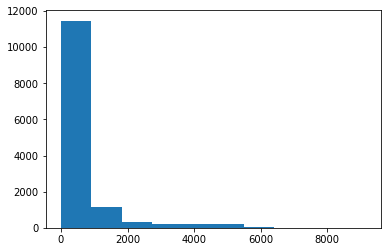

In [36]:
dists_arr = np.array(dists)
plt.hist(dists_arr)
print("< 1000: {}\n< 500: {}\n== 0: {}".format((dists_arr < 1000).sum() / len(dists_arr), 
      (dists_arr < 500).sum() / len(dists_arr),
      (dists_arr == 0).sum() / len(dists_arr)))

Text(0.5,1,'< 1000m')

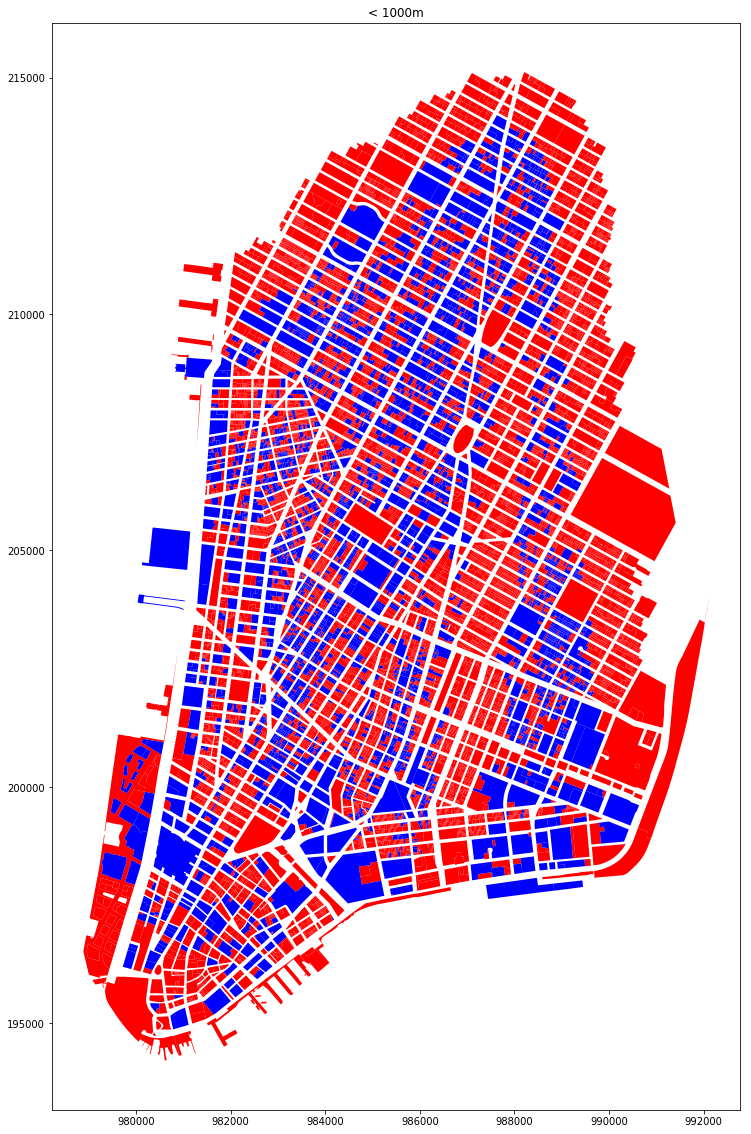

In [42]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 1000].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 1000m")

Text(0.5,1,'< 500m')

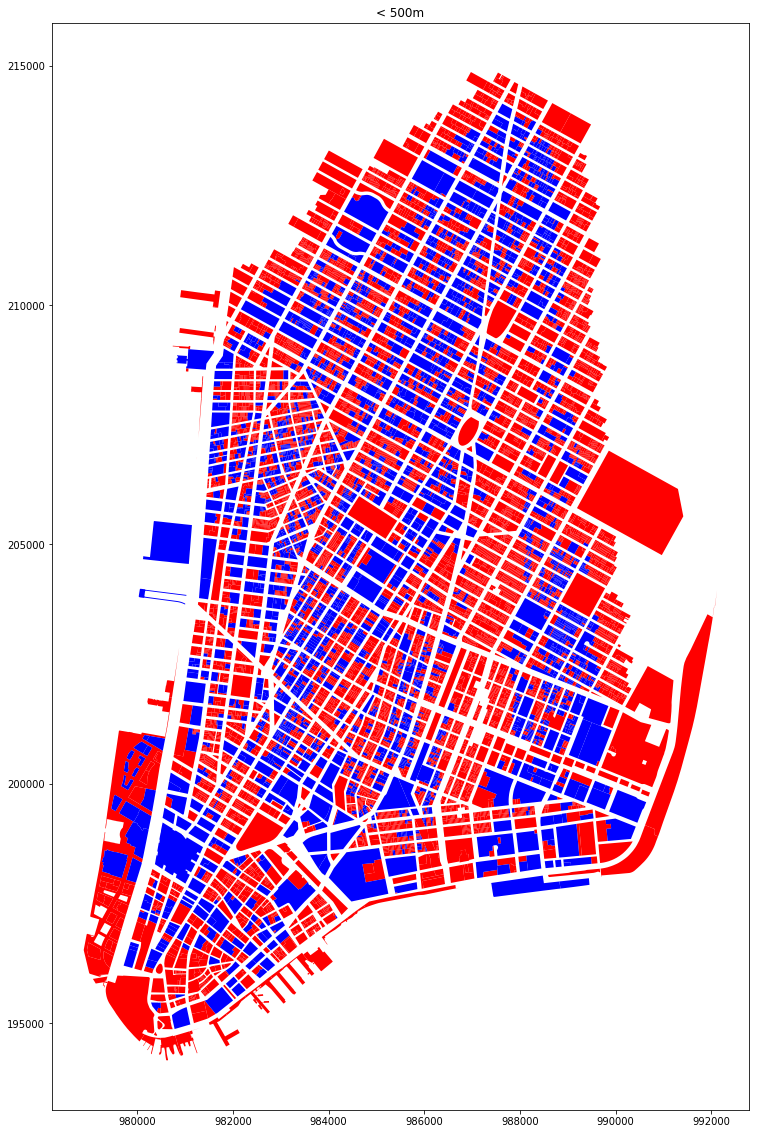

In [43]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 500].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 500m")